# Part 1: The Dynamics of Model Inversion

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras import layers, models, losses, metrics, optimizers
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer

## Dataset Overview: A Collection of Global Alphabets

The OmniGlot dataset, crafted for exploring concept learning and generalization in machine learning (Lake, Salakhutdinov, and Tenenbaum 2015) is a dataset comprised of hand-drawn characters from different alphabets. It was created in order to better challenge ML models, particularly on tasks related to generalization.

Dataset Structure
The OmniGlot dataset will be split into 2 different sets in order to have different stages of the model training and evaluation process:
Training Subset: This is used to train the target model. It is made up of characters from twenty different alphabets.
Adversary Training and Testing Subsets: The rest of the characters are split into 2 sets of 5 alphabets. One of these sets is used to train the attacker model, and the other is used to test the model's ability to reconstruct the input characters.

![Figure 1: A sample from the twenty-alphabet group used to train the target model](training_set_images.png)

Sample from the set utilized for adversary training:

![Figure 2: A sample from the five-alphabet set used to train the adversary](attacker_ds.png)


![Figure 3: A sample from the five-alphabet set used to test the adversary's reconstruction ability after training](actual_test_images.png)


In [ ]:
# Load the datasets
omni_train = tfds.load('omniglot', split='test')
omni_spy = tfds.load('omniglot', split='small1')
omni_test = tfds.load('omniglot', split='small2')

## Initial Steps in Training the Target Model

### Data Preparation for the Target Model

The dataset we start with includes several features:

- **Image**: Each image is 105x105 pixels.
- **Alphabet ID**: A unique identifier for the alphabet.
- **Character ID**: A unique identifier for each character within the dataset.
- **Label**: The classification label for the image.

Because we're only concerned with the original data and not the classification task:

1. **Discard Non-Essential Features**: Eliminate all features except for the alphabet ID and the image itself.
2. **Train the Model**: The target model is trained to classify characters by their respective alphabets.


In [ ]:
# Preprocess the images
def preprocess_image(image):
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return tf.image.rgb_to_grayscale(image)

In [ ]:
# Prepare the training dataset
train_ds = omni_train.take(11000).map(lambda record: (preprocess_image(record['image']), record['alphabet']))
train_ds = train_ds.shuffle(1000).batch(32)

# Prepare the validation dataset
val_ds = omni_train.skip(11000).map(lambda record: (preprocess_image(record['image']), record['alphabet']))
val_ds = val_ds.batch(32)

## Architecture of the Model

1. **Distributed Component (Stage One)**:
   - The first part of the model is operates on distributed systems, like mobile devices.
   - These devices process the data and are responsible for the intermediate model outputs.

2. **Centralized Component (Stage Two)**:
   - These intermediate outputs from the mobile devices are sent to a central server.
   - This server performs the final calculations to produce the results.

This two-stage setup mirrors the principles of federated learning, as described by McMahan et al. in 2016. The benefits of which are:

- **Privacy**: Training data remains on the devices, which should, in theory, enhance privacy.
- **Efficiency**: Reduced traffic to and from the server.

### Implementation Details

- **On-Device Model**: A convolutional neural network (CNN) on each mobile device.
- **Server Model**: A simple feedforward network for the server.

These combined gives us the `TargetModel`:

- When called, `TargetModel` executes both stages in order.
- However, we can also call `target_model$mobile_step()` separately in order to capture the intermediate results from stage 1.


In [ ]:
# Define the on-device model
on_device_model = models.Sequential([
    layers.Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=(105, 105, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=3),
    layers.Dropout(0.2),
    layers.Conv2D(32, kernel_size=(7, 7), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3, 3), strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(32, kernel_size=(5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Dropout(0.2),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Dropout(0.2),
])

In [ ]:
# Define the server model
server_model = models.Sequential([
    layers.Dense(256, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(50, activation='softmax')  # Assuming 50 classes
])

In [ ]:
# Define the custom target model
class TargetModel(models.Model):
    def __init__(self):
        super(TargetModel, self).__init__()
        self.on_device_model = on_device_model
        self.server_model = server_model

    def call(self, inputs):
        x = self.on_device_model(inputs)
        return self.server_model(x)

In [ ]:
model = TargetModel()

optimizer = tf.keras.optimizers.Adam()

# Compile the model
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Define the training and validation steps
train_loss = metrics.Mean(name='train_loss')
train_accuracy = metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = metrics.Mean(name='val_loss')
val_accuracy = metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [ ]:
# Initialize variables for early stopping and model checkpointing
best_val_loss = float('inf')
patience = 5
patience_counter = 0
min_delta = 0.01
best_model_weights = None  # to store the best model weights

In [ ]:
# Training loop
for epoch in range(100):
    print(f'Epoch: {epoch + 1} -----------')
    for images, labels in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        train_accuracy(labels, predictions)

    # Validation step
    for images, labels in val_ds:
        predictions = model(images)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
        val_loss(loss)
        val_accuracy(labels, predictions)

    # Print metrics
    print(f'Train accuracy: {train_accuracy.result()} Validation Accuracy: {val_accuracy.result()}')

    # Early stopping and model checkpointing check
    current_val_loss = val_loss.result()
    print(f'Validation loss: {current_val_loss}')
    if best_val_loss - current_val_loss > min_delta:
        best_val_loss = current_val_loss
        patience_counter = 0  # reset patience since we have improvement
        best_model_weights = model.get_weights()  # save the best model weights
    else:
        patience_counter += 1  # no improvement, so increase patience

    # Reset metrics after each epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Check if early stopping is triggered
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

Epoch: 1 -----------


2023-11-04 16:40:13.992403: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Train accuracy: 0.25327274203300476 Validation Accuracy: 0.44495412707328796
Validation loss: 1.7362033128738403
Epoch: 2 -----------
Train accuracy: 0.5238181948661804 Validation Accuracy: 0.5784403681755066
Validation loss: 1.3132944107055664
Epoch: 3 -----------
Train accuracy: 0.6265454292297363 Validation Accuracy: 0.6279816627502441
Validation loss: 1.164164423942566
Epoch: 4 -----------
Train accuracy: 0.6981818079948425 Validation Accuracy: 0.6871559619903564
Validation loss: 0.9743641018867493
Epoch: 5 -----------
Train accuracy: 0.7480000257492065 Validation Accuracy: 0.697706401348114
Validation loss: 0.9761723279953003
Epoch: 6 -----------
Train accuracy: 0.7870908975601196 Validation Accuracy: 0.747706413269043
Validation loss: 0.8017975687980652
Epoch: 7 -----------
Train accuracy: 0.821363627910614 Validation Accuracy: 0.7582568526268005
Validation loss: 0.7613825798034668
Epoch: 8 -----------
Train accuracy: 0.8442727327346802 Validation Accuracy: 0.7467889785766602
Val

## Training the Composite Model

- **Framework**: The model must be created as a custom model in Keras.
- **Training Approach**: We use TensorFlow 2.x techniques for training.

### Training Outcomes

- After completing **12 epochs** of training:
  - **Training Accuracy**: Approximately 0.90.
  - **Validation Accuracy**: Approximately 0.76.

These results are good, especially when considering the complexity of distinguishing between 20 different classes.


In [ ]:
# After training, load the best model weights
model.set_weights(best_model_weights)

## Adversary Model Training

### Objective
The adversary's goal is to reconstruct the original images from the target model's output using its own neural network.

### Strategy

1. **Input Preparation**: Use a small, substitute dataset as the input for the on-device model.
2. **Output Processing**: Treat the output from the on-device model as compressed versions of the original images.
3. **Model Training**: Train the adversary's model to be able to decode the compressed output in order to reconstruct the original images.
4. **Performance Measurement**: Measure the sucess or failure of the reconstruction by comparing it pixel-wise to the original images. Here, we're looking to minimize the MSE.

### Adversary Model Architecture
- The adversary's model is a deconvolutional network, which is similar to the decoder of an autoencoder.
- **Input Size**: The input for this model is a tensor with dimensions `batch_size x 1 x 1 x 32`.
- **Upsampling**: The model upsamples the input until it reaches the original resolution of 105x105 pixels.

This is the adversary's model's attempt to "reverse-engineer" the inputs.


In [ ]:
# Prepare the attacker dataset
attacker_ds = omni_spy.map(lambda record: (preprocess_image(record['image']), record['alphabet'])).batch(32)

In [ ]:
# Define the attack model
class AttackModel(tf.keras.Model):
    def __init__(self):
        super(AttackModel, self).__init__()
        self.conv1 = layers.Conv2DTranspose(filters=32, kernel_size=9, strides=1, activation='relu', padding='valid')
        self.conv2 = layers.Conv2DTranspose(filters=32, kernel_size=7, strides=2, activation='relu', padding='valid')
        self.conv3 = layers.Conv2DTranspose(filters=1, kernel_size=7, strides=2, activation='relu', padding='valid')
        self.conv4 = layers.Conv2DTranspose(filters=1, kernel_size=5, strides=2, activation='relu', padding='valid')

    def call(self, inputs):
        reshaped_input = tf.reshape(inputs, [-1, 1, 1, 50])
        x = self.conv1(reshaped_input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x

In [ ]:
# Instantiate the attack model
attacker = AttackModel()

# Define the loss function and the optimizer
attacker_criterion = losses.MeanSquaredError()
attacker_optimizer = optimizers.Adam()
attacker_loss_metric = metrics.Mean(name='attacker_loss')
attacker_mse_metric = metrics.MeanSquaredError(name='attacker_mse')

## Adversary Training Process

### Dataset Selection for the Adversary
- Select a **small subset** of 5 alphabets for training.
- It's very important that this subset does **not overlap** with the dataset used for the target model.

### Training Loop for the Adversary
- Focused on improving the decoding process.
- **100 short epochs**


In [ ]:
# Define the training step
@tf.function
def attacker_step(images):
    with tf.GradientTape() as tape:
        attack_input = model(images, training=False)  # Get the attack input from the target model
        generated = attacker(attack_input, training=True)
        loss = attacker_criterion(images, generated)
    gradients = tape.gradient(loss, attacker.trainable_variables)
    attacker_optimizer.apply_gradients(zip(gradients, attacker.trainable_variables))
    attacker_loss_metric(loss)
    attacker_mse_metric(images, generated)

In [ ]:
# Initialize variables for early stopping
best_mse = float('inf')
patience = 10
patience_counter = 0
min_delta = 0.0001

In [ ]:
# Training loop with early stopping
epoch = 0
while True:
    epoch += 1
    print(f'Epoch: {epoch} -----------')
    for images, _ in attacker_ds:
        attacker_step(images)

    current_mse = attacker_mse_metric.result().numpy()
    print(f'current mse: {current_mse}')
    print(f'best mse: {best_mse}')
    if best_mse - current_mse > min_delta:
        print(f'{best_mse - current_mse} is greater than {min_delta}, reset patience counter')
        best_mse = current_mse
        patience_counter = 0  # reset patience since we have improvement
        print(f'patience_counter: {patience_counter}')
    else:
        print(f'{best_mse - current_mse} is less than {min_delta}, increment patience counter')
        patience_counter += 1  # no improvement, so increase patience
        print(f'patience_counter: {patience_counter}')

    attacker_loss_metric.reset_states()
    attacker_mse_metric.reset_states()

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch} epochs.')
        break

Epoch: 1 -----------
current mse: 0.4302787780761719
best mse: inf
inf is greater than 0.0001, reset patience counter
patience_counter: 0
Epoch: 2 -----------
current mse: 0.14156952500343323
best mse: 0.4302787780761719
0.28870925307273865 is greater than 0.0001, reset patience counter
patience_counter: 0
Epoch: 3 -----------
current mse: 0.09805073589086533
best mse: 0.14156952500343323
0.0435187891125679 is greater than 0.0001, reset patience counter
patience_counter: 0
Epoch: 4 -----------
current mse: 0.08758791536092758
best mse: 0.09805073589086533
0.010462820529937744 is greater than 0.0001, reset patience counter
patience_counter: 0
Epoch: 5 -----------
current mse: 0.08305889368057251
best mse: 0.08758791536092758
0.004529021680355072 is greater than 0.0001, reset patience counter
patience_counter: 0
Epoch: 6 -----------
current mse: 0.07930225133895874
best mse: 0.08305889368057251
0.0037566423416137695 is greater than 0.0001, reset patience counter
patience_counter: 0
Epoch

## Evaluating the Adversary's Effectiveness

### The Central Question
- Can the adversary model accurately reconstruct the original data from the outputs of the first stage of the target model?

### Testing the Adversary
- To measure the adversary's ability to do this, we use a **third dataset** that includes images from 5 alphabets that this model has not previously seen.
- We'll display the results from the **first sixteen records** of this dataset.

In [ ]:
# Prepare the test dataset
test_ds = omni_test.map(lambda record: (preprocess_image(record['image']), record['alphabet'])).take(16).batch(16)

# Get a batch of images from the test dataset
for images, _ in test_ds.take(1):  # Take 1 batch
    break

## Adversary's Reconstruction Process

### Simulation of Real-World Attack
- In this testing phase, the adversary behaves the same way it would in a real-world attack - it queries the 1st stage of the target model to get the compressed data.

### Considerations in a Real Attack Scenario
- In an actual attack scenario, the adversary would not have direct access to be able to view the images.


In [ ]:
# Get the attack input from the target model
attack_input = model(images, training=False)

In [ ]:
# Generate images using the attack model
generated = attacker(attack_input, training=False)

In [ ]:
# Clip the values to [0, 1] range and remove the color channel dimension
generated = tf.clip_by_value(generated, 0, 1)
generated = tf.squeeze(generated, axis=-1)

# Convert to numpy array for plotting
generated = generated.numpy()

# Assuming 'images' contains the original images from the test dataset
original_images = images.numpy()

# Number of images to display
num_images = generated.shape[0]

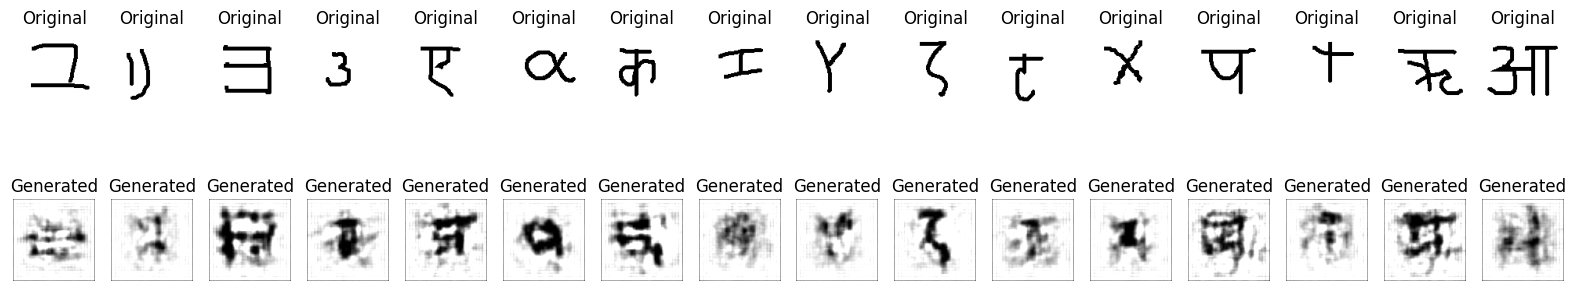

In [ ]:
# Set up the subplot grid - we need twice as many columns because we have two sets of images
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))  # Adjust the size as needed

# Plot original images
for i in range(num_images):
    ax = axes[0, i]
    ax.imshow(original_images[i], cmap='gray')  # Assuming the original images are grayscale
    ax.axis('off')
    ax.set_title('Original')

# Plot generated images
for i in range(num_images):
    ax = axes[1, i]
    ax.imshow(generated[i], cmap='gray')
    ax.axis('off')
    ax.set_title('Generated')

# Save the plot as a PNG file
plt.savefig('comparison_plot.png', bbox_inches='tight')

# Optionally, you can display the plot as well
plt.show()

## Assessing Privacy Implications of Reconstruction

### Complexity and Reconstruction Accuracy
- The accuracy of the adversary's reconstructions seems to have something to do with the complexity of the character it's attempting to reconstruct.
- Simple characters, like Greek and Roman letters, seem to be easier for the adversary to reconstruct.

### Privacy Concerns and Contextual Factors
- The degree to which privacy is impacted is actually dependent on the nature of the dataset:
  - **Classes vs. Individuals**: If the dataset represents classes, such as the letter X as a category, the privacy implications aren't as bad because the reconstruction would represent an example instead of a specific entity.
  - **Unique Individuals**: On the other hand, if the dataset has unique instances, such as if all Xs are images of the same person, Alex, then the ability to reconstruct X would equate to reconstructing the Alex's identity.

### Expert Evaluation and Differential Privacy
- As the complexities of these scenarios increases, it may be necessary to turn to experts in the relevant fields in order to determine the actual degree of privacy breached.
- **Quantitative Metrics**: Still, differential privacy has a quantitative metric to gauge privacy preservation, ϵ (epsilon), where a lower value is associated with better privacy.

### Experimentation with Differential Privacy
- We plan to re-conduct the above experiment using TensorFlow Privacy (TFP) to introduce noise and clip gradients during the training of the target model.


# Part 2: Implementing Differential Privacy


### Adapting the Experiment for Differential Privacy
- Because our model has both a "mobile" and a "server" component, we need to be implement a few custom things in order to use TDP.
- Luckily, TensorFlow 2.x can be adapted to be able to use differential privacy protocols.

### Data Preparation with Differential Privacy in Mind
- The training dataset is preprocessed and prepared in a similar way to before.



In [ ]:
# Load the datasets
omni_train = tfds.load('omniglot', split='test')
omni_spy = tfds.load('omniglot', split='small1')
omni_test = tfds.load('omniglot', split='small2')

# Preprocess the images
def preprocess_image(image):
    image = tf.cast(image, dtype=tf.float32) / 255.0
    return tf.image.rgb_to_grayscale(image)

batch_size = 32

# Convert string labels to integer labels
alphabet_list = sorted(set(tfds.as_dataframe(omni_train)['alphabet'].values))
alphabet_to_index = {alphabet: idx for idx, alphabet in enumerate(alphabet_list)}

# Ensure the keys are strings
keys_tensor = tf.constant([str(alphabet) for alphabet in alphabet_to_index.keys()], dtype=tf.string)
vals_tensor = tf.constant(list(alphabet_to_index.values()), dtype=tf.int64)

# Create a lookup table using the alphabet_to_index dictionary
alphabet_to_index_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys=keys_tensor, values=vals_tensor),
    default_value=-1
)

def convert_labels(image, label):
    # Convert label to string since the lookup table expects string keys
    label_str = tf.as_string(label)
    # Convert label to integer using the lookup table
    label_index = alphabet_to_index_table.lookup(label_str)
    return image, label_index

# Prepare the training dataset
train_ds = omni_train.take(11000).map(lambda record: (preprocess_image(record['image']), record['alphabet']))
train_ds = train_ds.map(lambda image, label: convert_labels(image, label))
train_ds = train_ds.shuffle(1000).batch(batch_size, drop_remainder=True)

# Prepare the validation dataset
val_ds = omni_train.skip(11000).map(lambda record: (preprocess_image(record['image']), record['alphabet']))
val_ds = val_ds.map(lambda image, label: convert_labels(image, label))
val_ds = val_ds.batch(batch_size, drop_remainder=True)


## Training the Target Model with TensorFlow Privacy

In order to build both the "mobile" and "server" stages into a one training process, we create a sequential model that is comprised of both layers.

In [ ]:
# Define the complete model
complete_model = Sequential([
    Conv2D(32, (7, 7), activation='relu', input_shape=(105, 105, 1)),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=3),
    Dropout(0.2),
    Conv2D(32, (7, 7), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),
    Dropout(0.2),
    Conv2D(32, (5, 5), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2),
    Dropout(0.2),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, name='mobile_output'),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(alphabet_list), activation='softmax')  # Adjust the number of outputs to match the number of alphabets
])

## Implementing TensorFlow Privacy (TFP)

A main feature of TFP is the use of a specialized optimizer. This optimizer is designed to clip gradients to a specific size as well as add a predefined amount of noise. The `noise_multiplier` parameter can be adjusted to achieve different levels of privacy (different ϵ values).

In [ ]:
# Define the optimizer with differential privacy
l2_norm_clip = 1.0
noise_multiplier = 0.3  # Change this value for different ε
num_microbatches = batch_size // 4
learning_rate = 0.005

In [ ]:
optimizer = DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

## Individual-Level Loss and Gradient Computation

Something that does need to be adjusted it the calcluation of the loss and gradients - these must be done at the individual data point level as opposed to in aggregate as was done originally.

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)
complete_model.compile(optimizer=optimizer, loss=loss, metrics=['sparse_categorical_accuracy'])

In [ ]:
# Train the model
num_epochs = 20
n_train = 13180  # Total number of training examples

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = complete_model(images, training=True)
        loss_value = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=False)
    grads_and_vars = optimizer._compute_gradients(loss_value, complete_model.trainable_variables, tape=tape)
    optimizer.apply_gradients(grads_and_vars)
    train_loss(loss_value)
    train_accuracy(labels, predictions)

@tf.function
def val_step(images, labels):
    predictions = complete_model(images, training=False)
    v_loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
    val_loss(v_loss)
    val_accuracy(labels, predictions)

In [ ]:
best_model_weights = None  # Initialize variable to store the best model weights
best_val_loss, current_val_loss = float('inf'), float('inf')  # Initialize best validation loss to infinity
patience_counter = 0  # Initialize patience counter
min_delta = 0.001  # Define a threshold for minimum change in validation loss to qualify as an improvement
patience = 10  # Define how many epochs to wait for improvement before stopping

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch: {epoch + 1} -----------')
    for images, labels in train_ds:
        train_step(images, labels)

    for images, labels in val_ds:
        val_step(images, labels)

    # Print metrics
    print(f'Train accuracy: {train_accuracy.result()} Validation Accuracy: {val_accuracy.result()}')

    # Early stopping and model checkpointing check
    current_val_loss = val_loss.result()
    print(f'Validation loss: {current_val_loss}')
    if best_val_loss - current_val_loss > min_delta:
        best_val_loss = current_val_loss
        patience_counter = 0  # reset patience since we have improvement
        best_model_weights = model.get_weights()  # save the best model weights
    else:
        patience_counter += 1  # no improvement, so increase patience

    # Reset metrics after each epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Check if early stopping is triggered
    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch + 1} epochs.')
        break

## Preparing the Adversary's Model

In order to be able to properly simulate a real world adversary, we truncate the second-stage layers. This allows us to isolate the logic from the 1st stage. Then, we save the model's weights which allows the adversary to use the truncated version.

In [ ]:
# Save the "mobile" part of the model
mobile_model = models.Model(inputs=complete_model.input, outputs=complete_model.get_layer("mobile_output").output)
mobile_model.save_weights('intercepted.hdf5')

In [ ]:
from tensorflow_privacy import compute_dp_sgd_privacy

# Compute the privacy budget
epsilon = compute_dp_sgd_privacy(
    n=n_train,
    batch_size=batch_size,
    noise_multiplier=noise_multiplier,
    epochs=num_epochs,
    delta=1e-5
)[0]

print(f'Epsilon: {epsilon}')

Epsilon: 82.15974923253977


In [ ]:
# Define the custom target model
class TargetModel(models.Model):
    def __init__(self):
        super(TargetModel, self).__init__()
        self.on_device_model = on_device_model
        self.server_model = server_model

    def call(self, inputs):
        x = self.on_device_model(inputs)
        return self.server_model(x)

In [ ]:
# Create an instance of the target model
target_model_instance = TargetModel()

# Load the weights into the on_device part of the model
target_model_instance.on_device_model.load_weights('intercepted.hdf5')

## Training the Adversary Against a Differentially Private Target

The adversary's training mostly mirrors the original implementation. The target model's definition doesn't change.

In [ ]:
# Continue with the adversary training as before
# Instantiate the attack model
attacker = AttackModel()

# Define the loss function and the optimizer
attacker_criterion = losses.MeanSquaredError()
attacker_optimizer = optimizers.Adam(learning_rate=0.01)
attacker_loss_metric = metrics.Mean(name='attacker_loss')
attacker_mse_metric = metrics.MeanSquaredError(name='attacker_mse')

In [ ]:
# Define the training step
@tf.function
def attacker_step(images):
    with tf.GradientTape() as tape:
        attack_input = target_model_instance(images, training=False)  # Get the attack input from the target model
        generated = attacker(attack_input, training=True)
        loss = attacker_criterion(images, generated)
    gradients = tape.gradient(loss, attacker.trainable_variables)
    attacker_optimizer.apply_gradients(zip(gradients, attacker.trainable_variables))
    attacker_loss_metric(loss)
    attacker_mse_metric(images, generated)

In [ ]:
# Initialize variables for early stopping
patience = 10
patience_counter = 0
min_delta = 0.0001
best_weights = None  # This will store the best weights
current_mse, best_mse = float('inf'), float('inf')

In [ ]:
# Training loop with early stopping
epoch = 0
while True:
    epoch += 1
    print(f'Epoch: {epoch} -----------')
    for images, _ in attacker_ds:
        attacker_step(images)

    current_mse = attacker_mse_metric.result().numpy()
    print(f'current mse: {current_mse}')
    print(f'best mse: {best_mse}')
    if best_mse - current_mse > min_delta:
        print(f'{best_mse - current_mse} is greater than {min_delta}, saving best model')
        best_mse = current_mse
        best_weights = attacker.get_weights()  # Save the best weights
        patience_counter = 0  # reset patience since we have improvement
        print(f'patience_counter: {patience_counter}')
    else:
        print(f'{best_mse - current_mse} is less than {min_delta}, increment patience counter')
        patience_counter += 1  # no improvement, so increase patience
        print(f'patience_counter: {patience_counter}')

    attacker_loss_metric.reset_states()
    attacker_mse_metric.reset_states()

    if patience_counter >= patience:
        print(f'Early stopping triggered after {epoch} epochs.')
        break

Epoch: 1 -----------
current mse: 0.15260954201221466
best mse: inf
inf is greater than 0.0001, saving best model
patience_counter: 0
Epoch: 2 -----------
current mse: 0.07079955190420151
best mse: 0.15260954201221466
0.08180999010801315 is greater than 0.0001, saving best model
patience_counter: 0
Epoch: 3 -----------
current mse: 0.06721016019582748
best mse: 0.07079955190420151
0.0035893917083740234 is greater than 0.0001, saving best model
patience_counter: 0
Epoch: 4 -----------
current mse: 0.0653875470161438
best mse: 0.06721016019582748
0.0018226131796836853 is greater than 0.0001, saving best model
patience_counter: 0
Epoch: 5 -----------
current mse: 0.06385715305805206
best mse: 0.0653875470161438
0.0015303939580917358 is greater than 0.0001, saving best model
patience_counter: 0
Epoch: 6 -----------
current mse: 0.06248382106423378
best mse: 0.06385715305805206
0.001373331993818283 is greater than 0.0001, saving best model
patience_counter: 0
Epoch: 7 -----------
current ms

In [ ]:
# After the training loop, if best_weights is not None, load them into the model
if best_weights is not None:
    attacker.set_weights(best_weights)
    print("Loaded the best model weights based on validation loss.")

Loaded the best model weights based on validation loss.


## Evaluating the Adversary's Performance with Differential Privacy

The testing procedure for the adversary remains unchanged. However, because we're now using DP, we need to assess the adversary's effectiveness.

In [ ]:
# Prepare the test dataset
test_ds = omni_test.map(lambda record: (preprocess_image(record['image']), record['alphabet'])).take(16).batch(16)

# Get a batch of images from the test dataset
for images, _ in test_ds.take(1):  # Take 1 batch
    break

# Get the attack input from the target model
attack_input = target_model_instance(images, training=False)

# Generate images using the attack model
generated = attacker(attack_input, training=False)

# Clip the values to [0, 1] range and remove the color channel dimension
generated = tf.clip_by_value(generated, 0, 1)
generated = tf.squeeze(generated, axis=-1)

# Convert to numpy array for plotting
privacy_generated = generated.numpy()

# Assuming 'images' contains the original images from the test dataset
original_images = images.numpy()

# Number of images to display
num_images = generated.shape[0]

# Set up the subplot grid - we need twice as many columns because we have two sets of images
fig, axes = plt.subplots(2, num_images, figsize=(20, 4))  # Adjust the size as needed

# Plot original images
for i in range(num_images):
    ax = axes[0, i]
    ax.imshow(original_images[i], cmap='gray')  # Assuming the original images are grayscale
    ax.axis('off')
    ax.set_title('Original')

# Plot generated images
for i in range(num_images):
    ax = axes[1, i]
    ax.imshow(privacy_generated[i], cmap='gray')
    ax.axis('off')
    ax.set_title('w/ dp')

# Save the plot as a PNG file
plt.savefig('privacy_comparison_plot.png', bbox_inches='tight')

## Testing the Adversary Against a Differentially Private Target

With the ackowledgement that privacy concerns are often context-dependent, it does seem that the DP implementation has helped to mitigate the adversary's ability to reconstruct the original input data.

Below are the results from the iteration with the least amount of noise introduced:

In [ ]:
plt.show()

![Figure 4: Attacker result with Differential Privacy](privacy_comparison_plot.png)